<a href="https://colab.research.google.com/github/g2246462796/dive_into_deep_learning/blob/main/5%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0%E8%AE%A1%E7%AE%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

除了庞大的数据集和强大的硬件， 优秀的软件工具在深度学习的快速发展中发挥了不可或缺的作用。 从2007年发布的开创性的Theano库开始， 灵活的开源工具使研究人员能够快速开发模型原型， 避免了我们使用标准组件时的重复工作， 同时仍然保持了我们进行底层修改的能力。 随着时间的推移，深度学习库已经演变成提供越来越粗糙的抽象。 就像半导体设计师从指定晶体管到逻辑电路再到编写代码一样， 神经网络研究人员已经从考虑单个人工神经元的行为转变为从层的角度构思网络， **通常在设计架构时考虑的是更粗糙的块（block）。**

之前我们已经介绍了一些基本的机器学习概念， 并慢慢介绍了功能齐全的深度学习模型。 在上一章中，我们从零开始实现了多层感知机的每个组件， 然后展示了如何利用高级API轻松地实现相同的模型。 为了易于学习，我们调用了深度学习库，但是跳过了它们工作的细节。 在本章中，我们将深入探索深度学习计算的关键组件， 即模型构建、参数访问与初始化、设计自定义层和块、将模型读写到磁盘， 以及利用GPU实现显著的加速。 这些知识将使读者从深度学习“基础用户”变为“高级用户”。 虽然本章不介绍任何新的模型或数据集， 但后面的高级模型章节在很大程度上依赖于本章的知识。

# 5.1 层和块

之前首次介绍神经网络时，我们关注的是具有单一输出的线性模型。 在这里，整个模型只有一个输出。 注意，单个神经网络 （1）接受一些输入； （2）生成相应的标量输出； （3）具有一组相关 参数（parameters），更新这些参数可以优化某目标函数。

然后，当考虑具有多个输出的网络时， 我们利用矢量化算法来描述整层神经元。 像单个神经元一样，层（1）接受一组输入， （2）生成相应的输出， （3）由一组可调整参数描述。 当我们使用softmax回归时，一个单层本身就是模型。 然而，即使我们随后引入了多层感知机，我们仍然可以认为该模型保留了上面所说的基本架构。

对于多层感知机而言，整个模型及其组成层都是这种架构。 整个模型接受原始输入（特征），生成输出（预测）， 并包含一些参数（所有组成层的参数集合）。 同样，每个单独的层接收输入（由前一层提供）， 生成输出（到下一层的输入），并且具有一组可调参数， 这些参数根据从下一层反向传播的信号进行更新。

事实证明，研究讨论“比单个层大”但“比整个模型小”的组件更有价值。 例如，在计算机视觉中广泛流行的ResNet-152架构就有数百层， 这些层是由层组（groups of layers）的重复模式组成。 这个ResNet架构赢得了2015年ImageNet和COCO计算机视觉比赛 的识别和检测任务 (He et al., 2016)。 目前ResNet架构仍然是许多视觉任务的首选架构。 在其他的领域，如自然语言处理和语音， 层组以各种重复模式排列的类似架构现在也是普遍存在。

为了实现这些复杂的网络，我们引入了神经网络块的概念。 块（block）可以描述单个层、由多个层组成的组件或整个模型本身。 使用块进行抽象的一个好处是可以将一些块组合成更大的组件， 这一过程通常是递归的，如 图5.1.1所示。 通过定义代码来按需生成任意复杂度的块， 我们可以通过简洁的代码实现复杂的神经网络。

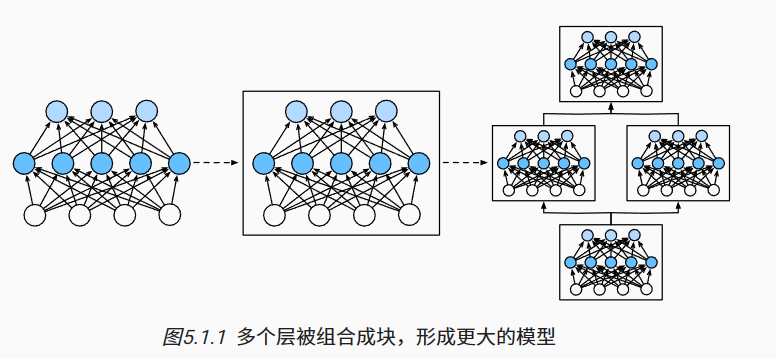

从编程的角度来看，块由类（class）表示。 它的任何子类都必须定义一个将其输入转换为输出的前向传播函数， 并且必须存储任何必需的参数。 注意，有些块不需要任何参数。 最后，为了计算梯度，块必须具有反向传播函数。 在定义我们自己的块时，由于自动微分（在 2.5节 中引入） 提供了一些后端实现，我们只需要考虑前向传播函数和必需的参数。

在构造自定义块之前，我们先回顾一下多层感知机 （ 4.3节 ）的代码。 下面的代码生成一个网络，其中包含一个具有256个单元和ReLU激活函数的全连接隐藏层， 然后是一个具有10个隐藏单元且不带激活函数的全连接输出层。

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10))

X = torch.rand(2,20)
net(X)

tensor([[ 0.3760, -0.2099, -0.0949,  0.0819, -0.0301,  0.1649,  0.2153,  0.0086,
          0.0545,  0.1517],
        [ 0.4015, -0.0815,  0.0222,  0.0655, -0.1239,  0.1854,  0.1615, -0.0558,
          0.0509,  0.0379]], grad_fn=<AddmmBackward0>)

在这个例子中，我们通过实例化nn.Sequential来构建我们的模型， 层的执行顺序是作为参数传递的。

简而言之，nn.Sequential定义了一种特殊的Module， 即在PyTorch中表示一个块的类， 它维护了一个由Module组成的有序列表。 注意，两个全连接层都是Linear类的实例， Linear类本身就是Module的子类。 另外，到目前为止，我们一直在通过net(X)调用我们的模型来获得模型的输出。 这实际上是net.__call__(X)的简写。 这个前向传播函数非常简单： 它将列表中的每个块连接在一起，将每个块的输出作为下一个块的输入。

## 5.1.1 自定义块

要想直观地了解块是如何工作的，最简单的方法就是自己实现一个。 在实现我们自定义块之前，我们简要总结一下每个块必须提供的基本功能。

1.将输入数据作为其前向传播函数的参数。

2.通过前向传播函数来生成输出。请注意，输出的形状可能与输入的形状不同。例如，我们上面模型中的第一个全连接的层接收一个20维的输入，但是返回一个维度为256的输出。

3.计算其输出关于输入的梯度，可通过其反向传播函数进行访问。通常这是自动发生的。

4.存储和访问前向传播计算所需的参数。

5.根据需要初始化模型参数。

在下面的代码片段中，我们从零开始编写一个块。 它包含一个多层感知机，其具有256个隐藏单元的隐藏层和一个10维输出层。 注意，下面的MLP类继承了表示块的类。 我们的实现只需要提供我们自己的构造函数（Python中的__init__函数）和前向传播函数。

In [ ]:
class MLP(nn.Module):
  # 用模型参数声明层。这里，我们声明两个全连接的层
  def __init__(self):
    # 调用MLP的父类Module的构造函数来执行必要的初始化
    # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params(稍后将介绍)
    super().__init__()
    self.hidden = nn.Linear(20,256) # 隐藏层
    self.out = nn.Linear(256,10) # 输出层

  # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
  def forward(self,X):
    # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
    return self.out(F.relu(self.hidden(X)))

我们首先看一下前向传播函数，它以X作为输入， 计算带有激活函数的隐藏表示，并输出其未规范化的输出值。 在这个MLP实现中，两个层都是实例变量。 要了解这为什么是合理的，可以想象实例化两个多层感知机（net1和net2）， 并根据不同的数据对它们进行训练。 当然，我们希望它们学到两种不同的模型。

接着我们实例化多层感知机的层，然后在每次调用前向传播函数时调用这些层。 注意一些关键细节： 首先，我们定制的__init__函数通过super().__init__() 调用父类的__init__函数， 省去了重复编写模版代码的痛苦。 然后，我们实例化两个全连接层， 分别为self.hidden和self.out。 注意，除非我们实现一个新的运算符， 否则我们不必担心反向传播函数或参数初始化， 系统将自动生成这些。

我们来试一下这个函数：

In [ ]:
net = MLP()
net(X)

tensor([[ 0.0258,  0.2228,  0.2287,  0.1468,  0.0391, -0.1235, -0.1396, -0.0400,
          0.0225, -0.1728],
        [ 0.1417,  0.0813,  0.1853,  0.0627,  0.0093, -0.0329, -0.1041, -0.0418,
          0.0143, -0.1331]], grad_fn=<AddmmBackward0>)

块的一个主要优点是它的多功能性。 我们可以子类化块以创建层（如全连接层的类）、 整个模型（如上面的MLP类）或具有中等复杂度的各种组件。 我们在接下来的章节中充分利用了这种多功能性， 比如在处理卷积神经网络时。

## 5.1.2 顺序块

现在我们可以更仔细地看看Sequential类是如何工作的， 回想一下Sequential的设计是为了把其他模块串起来。 为了构建我们自己的简化的MySequential， 我们只需要定义两个关键函数：

1. 一种将块逐个追加到列表中的函数
2. 一种前向传播函数，用于将输入按追加块的顺序传递给块组成的“链条”

下面的MySequential类提供了与默认Sequential类相同的功能。

In [ ]:
class MySequential(nn.Module):
  def __init__(self,*args):
    super().__init__()
    for idx,module in enumerate(args):
      # 这里,module是Module子类的一个实例。我们把它保存在'Module'类的成员
      # 变量_modules中。_mudule的类型是OrderedDict
      self._modules[str(idx)] = module
  def forward(self,X):
    # OrderedDict保证了按照成员添加的顺序遍历它们
    for block in self._modules.values():
      X = block(X)
    return X

__init__函数将每个模块逐个添加到有序字典_modules中。 读者可能会好奇为什么每个Module都有一个_modules属性？ 以及为什么我们使用它而不是自己定义一个Python列表？ 简而言之，_modules的主要优点是： 在模块的参数初始化过程中， 系统知道在_modules字典中查找需要初始化参数的子块。

当MySequential的前向传播函数被调用时， 每个添加的块都按照它们被添加的顺序执行。 现在可以使用我们的MySequential类重新实现多层感知机。

In [ ]:
net = MySequential(nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10))
net(X)

tensor([[-0.0535, -0.0768, -0.0099, -0.0374,  0.0804,  0.0080, -0.2774,  0.0313,
          0.0207,  0.3020],
        [ 0.0508, -0.0308, -0.0020, -0.0229,  0.0669, -0.0033, -0.1224,  0.0013,
          0.0305,  0.1601]], grad_fn=<AddmmBackward0>)

## 5.1.3 在前向传播函数中执行代码

Sequential类使模型构造变得简单， 允许我们组合新的架构，而不必定义自己的类。 然而，并不是所有的架构都是简单的顺序架构。 当需要更强的灵活性时，我们需要定义自己的块。 例如，我们可能希望在前向传播函数中执行Python的控制流。 此外，我们可能希望执行任意的数学运算， 而不是简单地依赖预定义的神经网络层。

到目前为止， 我们网络中的所有操作都对网络的激活值及网络的参数起作用。 然而，有时我们可能希望合并既不是上一层的结果也不是可更新参数的项， 我们称之为**常数参数**（constant parameter）。

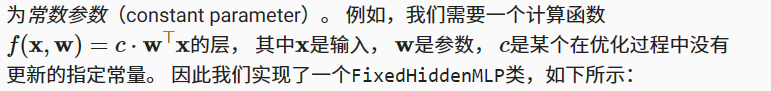

In [ ]:
class FixedHiddenMLP(nn.Module):
  def __init__(self):
    super().__init__()
    # 不计算梯度的随机权重参数。因此其在训练期间保持不变
    self.rand_weight = torch.rand((20,20),requires_grad=False)
    self.linear = nn.Linear(20,20)

  def forward(self,X):
    X = self.linear(X)
    # 使用创建的常量参数以及relu和mm函数
    X = F.relu(torch.mm(X,self.rand_weight)+1)
    # 复用全连接层。这相当于两个全连接层共享参数
    X = self.linear(X)
    # 控制流
    while X.abs().sum() > 1:
      X /=2
    return X.sum()

在这个FixedHiddenMLP模型中，我们实现了一个隐藏层， 其权重（self.rand_weight）在实例化时被随机初始化，之后为常量。 这个权重不是一个模型参数，因此它永远不会被反向传播更新。 然后，神经网络将这个固定层的输出通过一个全连接层。

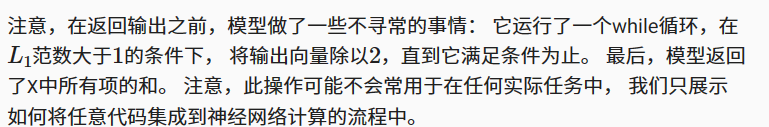

In [ ]:
net = FixedHiddenMLP()
net(X)

tensor(-0.0081, grad_fn=<SumBackward0>)

我们可以混合搭配各种组合块的方法。 在下面的例子中，我们以一些想到的方法嵌套块。

In [ ]:
class NestMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(20,64),nn.ReLU(),nn.Linear(64,32),nn.ReLU())
    self.linear = nn.Linear(32,16)
  def forward(self,X):
    return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(),nn.Linear(16,20),FixedHiddenMLP())
chimera(X)

tensor(-0.1042, grad_fn=<SumBackward0>)

## 5.1.4 效率

读者可能会开始担心操作效率的问题。 毕竟，我们在一个高性能的深度学习库中进行了大量的字典查找、 代码执行和许多其他的Python代码。 Python的问题全局解释器锁 是众所周知的。 在深度学习环境中，我们担心速度极快的GPU可能要等到CPU运行Python代码后才能运行另一个作业。

## 5.1.5 小结



*   一个块可以由许多层组成；一个块可以由许多块组成。

*   块可以包含代码。
*   块负责大量的内部处理，包括参数初始化和反向传播。


*   层和块的顺序连接由Sequential块处理。



# 5.2 参数管理

在选择了架构并设置了超参数后，我们就进入了训练阶段。 此时，我们的目标是找到使损失函数最小化的模型参数值。 经过训练后，我们将需要使用这些参数来做出未来的预测。 此外，有时我们希望提取参数，以便在其他环境中复用它们， 将模型保存下来，以便它可以在其他软件中执行， 或者为了获得科学的理解而进行检查。

之前的介绍中，我们只依靠深度学习框架来完成训练的工作， 而忽略了操作参数的具体细节。 本节，我们将介绍以下内容：



*   访问参数，用于调试、诊断和可视化；
*   参数初始化；
*   在不同模型组件间共享参数。



我们首先看一下具有单隐藏层的多层感知机。

In [ ]:
import torch
from torch import nn
net = nn.Sequential(nn.Linear(4,8),nn.ReLU(),nn.Linear(8,1))
X = torch.rand(size=(2,4))
net(X)

tensor([[0.0644],
        [0.1126]], grad_fn=<AddmmBackward0>)

## 5.2.1 参数访问

我们从已有模型中访问参数。 当通过Sequential类定义模型时， 我们可以通过索引来访问模型的任意层。 这就像模型是一个列表一样，每层的参数都在其属性中。 如下所示，我们可以检查第二个全连接层的参数。

In [ ]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[ 0.3319, -0.2165,  0.1253, -0.2281, -0.2593, -0.2246,  0.0959, -0.1922]])), ('bias', tensor([0.1877]))])


输出的结果告诉我们一些重要的事情： 首先，这个全连接层包含两个参数，分别是该层的权重和偏置。 两者都存储为单精度浮点数（float32）。 注意，参数名称允许唯一标识每个参数，即使在包含数百个层的网络中也是如此。

### 5.2.1.1 目标参数

注意，每个参数都表示为参数类的一个实例。 要对参数执行任何操作，首先我们需要访问底层的数值。 有几种方法可以做到这一点。有些比较简单，而另一些则比较通用。 下面的代码从第二个全连接层（即第三个神经网络层）提取偏置， 提取后返回的是一个参数类实例，并进一步访问该参数的值。

In [ ]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.1877], requires_grad=True)
tensor([0.1877])


参数是复合的对象，包含值、梯度和额外信息。 这就是我们需要显式参数值的原因。 除了值之外，我们还可以访问每个参数的梯度。 在上面这个网络中，由于我们还没有调用反向传播，所以参数的梯度处于初始状态。

In [ ]:
net[2].weight.grad == None

True

## 5.2.1.2 一次性访问所有参数

当我们需要对所有参数执行操作时，逐个访问它们可能会很麻烦。 当我们处理更复杂的块（例如，嵌套块）时，情况可能会变得特别复杂， 因为我们需要递归整个树来提取每个子块的参数。 下面，我们将通过演示来比较访问第一个全连接层的参数和访问所有层。

In [ ]:
print(*[(name,param.shape) for name,param in net[0].named_parameters()])
print(*[(name,param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


这为我们提供了另一种访问网络参数的方式，如下所示。

In [ ]:
net.state_dict()['2.bias'].data

tensor([0.1877])

### 5.2.1.3 从嵌套块来收集参数

让我们看看，如果我们将多个块相互嵌套，参数命名约定是如何工作的。 我们首先定义一个生成块的函数（可以说是“块工厂”），然后将这些块组合到更大的块中。

In [ ]:
def block1():
  return nn.Sequential(nn.Linear(4,8),nn.ReLU(),nn.Linear(8,4),nn.ReLU())

def block2():
  net = nn.Sequential()
  for i in range(4):
    # 在这里嵌套
    net.add_module(f'block{i}',block1())
  return net

rgnet = nn.Sequential(block2(),nn.Linear(4,1))
rgnet(X)

tensor([[0.5603],
        [0.5603]], grad_fn=<AddmmBackward0>)

设计了网络后，我们看看它是如何工作的。

In [ ]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


因为层是分层嵌套的，所以我们也可以像通过嵌套列表索引一样访问它们。 下面，我们访问第一个主要的块中、第二个子块的第一层的偏置项。

In [ ]:
rgnet[0][1][0].bias.data

tensor([ 0.2341,  0.4982, -0.4498, -0.1477,  0.1836,  0.3503,  0.1538, -0.3177])

## 5.2.2 参数初始化

知道了如何访问参数后，现在我们看看如何正确地初始化参数。 我们在 4.8节中讨论了良好初始化的必要性。 深度学习框架提供默认随机初始化， 也允许我们创建自定义初始化方法， 满足我们通过其他规则实现初始化权重。

默认情况下，PyTorch会根据一个范围均匀地初始化权重和偏置矩阵， 这个范围是根据输入和输出维度计算出的。 PyTorch的nn.init模块提供了多种预置初始化方法。

### 5.2.2.1 内置初始化

让我们首先调用内置的初始化器。 下面的代码将所有权重参数初始化为标准差为0.01的高斯随机变量， 且将偏置参数设置为0。

In [ ]:
def init_normal(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight,mean=0,std=0.01)
    nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0],net[0].bias.data[0]

(tensor([ 0.0059,  0.0071, -0.0081, -0.0008]), tensor(0.))

我们还可以将所有参数初始化为给定的常数，比如初始化为1。

In [ ]:
def init_constant(m):
  if type(m) == nn.Linear:
    nn.init.constant_(m.weight,1)
    nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0],net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

我们还可以对某些块应用不同的初始化方法。 例如，下面我们使用Xavier初始化方法初始化第一个神经网络层， 然后将第三个神经网络层初始化为常量值42。

In [ ]:
def init_xavier(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
def init_42(m):
  if type(m) == nn.Linear:
    nn.init.constant_(m.weight,42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.3603,  0.6705,  0.3418,  0.5000])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


### 5.2.2.2 自定义初始化

有时，深度学习框架没有提供我们需要的初始化方法。 在下面的例子中，我们使用以下的分布为任意权重参数w定义初始化方法：

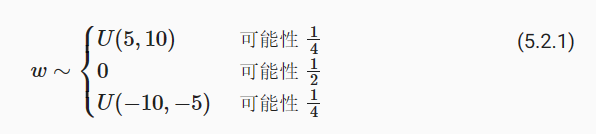

同样，我们实现了一个my_init函数来应用到net。

In [ ]:
def my_init(m):
  if type(m) == nn.Linear:
    print("Init",*[(name,param.shape) for name,param in m.named_parameters()][0])
    nn.init.uniform_(m.weight,-10,10)
    m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-6.4974,  9.0624,  0.0000,  0.0000],
        [ 8.4370,  0.0000, -6.5710, -0.0000]], grad_fn=<SliceBackward0>)

注意，我们始终可以直接设置参数。

In [ ]:
net[0].weight.data[:] +=1
net[0].weight.data[0,0] = 42
net[0].weight.data[0]

tensor([42.0000, 10.0624,  1.0000,  1.0000])

## 5.2.3 参数绑定

有时我们希望在多个层间共享参数： 我们可以定义一个稠密层，然后使用它的参数来设置另一个层的参数。

In [ ]:
# 我们需要给共享层一个名称，以便可以引用它的参数
shared = nn.Linear(8,8)
net = nn.Sequential(nn.Linear(4,8),nn.ReLU(),
                    shared,nn.ReLU(),
                    shared,nn.ReLU(),
                    nn.Linear(8,1))
net(X)
# 检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0,0] = 100
# 确保它们实际上是同一个对象，而不只是有相同的值
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


这个例子表明第三个和第五个神经网络层的参数是绑定的。 它们不仅值相等，而且由相同的张量表示。 因此，如果我们改变其中一个参数，另一个参数也会改变。 这里有一个问题：当参数绑定时，梯度会发生什么情况？

答案是由于模型参数包含梯度，因此在反向传播期间第二个隐藏层 （即第三个神经网络层）和第三个隐藏层（即第五个神经网络层）的梯度会加在一起。

## 5.2.4 小结



*   我们有几种方法可以访问、初始化和绑定模型参数。
*   我们可以使用自定义初始化方法。



# 5.3 延后初始化

到目前为止，我们忽略了建立网络时需要做的以下这些事情：



*   我们定义了网络架构，但没有指定输入维度。
*   我们添加层时没有指定前一层的输出维度。
*   我们在初始化参数时，甚至没有足够的信息来确定模型应该包含多少参数。



有些读者可能会对我们的代码能运行感到惊讶。 毕竟，深度学习框架无法判断网络的输入维度是什么。 这里的诀窍是框架的延后初始化（defers initialization）， 即直到数据第一次通过模型传递时，框架才会动态地推断出每个层的大小。

在以后，当使用卷积神经网络时， 由于输入维度（即图像的分辨率）将影响每个后续层的维数， 有了该技术将更加方便。 现在我们在编写代码时无须知道维度是什么就可以设置参数， 这种能力可以大大简化定义和修改模型的任务。 接下来，我们将更深入地研究初始化机制。

## 5.3.1 实例化网络

In [ ]:
import torch
from torch import nn

"""延后初始化"""
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
# print(net[0].weight)  # 尚未初始化
print(net)



Sequential(
  (0): LazyLinear(in_features=0, out_features=256, bias=True)
  (1): ReLU()
  (2): LazyLinear(in_features=0, out_features=10, bias=True)
)


这里没有指定输入层的维度，因此输入层维度默认是0

In [ ]:
X = torch.rand(2, 20)
net(X)
print(net)

Sequential(
  (0): Linear(in_features=20, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)


## 5.3.2 小结



*   延后初始化使框架能够自动推断参数形状，使修改模型架构变得容易，避免了一些常见的错误。
*   我们可以通过模型传递数据，使框架最终初始化参数。



# 5.4 自定义层

深度学习成功背后的一个因素是神经网络的灵活性： 我们可以用创造性的方式组合不同的层，从而设计出适用于各种任务的架构。

例如，研究人员发明了专门用于处理图像、文本、序列数据和执行动态规划的层。 有时我们会遇到或要自己发明一个现在在深度学习框架中还不存在的层。 在这些情况下，必须构建自定义层。本节将展示如何构建自定义层。

## 5.4.1 不带参数的层

首先，我们构造一个没有任何参数的自定义层。 回忆一下在 5.1节对块的介绍， 这应该看起来很眼熟。 下面的CenteredLayer类要从其输入中减去均值。 要构建它，我们只需继承基础层类并实现前向传播功能。

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn

class CenteredLayer(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,X):
    return X - X.mean()

让我们向该层提供一些数据，验证它是否能按预期工作。

In [ ]:
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

现在，我们可以将层作为组件合并到更复杂的模型中。

In [ ]:
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

作为额外的健全性检查，我们可以在向该网络发送随机数据后，检查均值是否为0。 由于我们处理的是浮点数，因为存储精度的原因，我们仍然可能会看到一个非常小的非零数。

In [ ]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(-2.7940e-09, grad_fn=<MeanBackward0>)

## 5.4.2 带参数的层

以上我们知道了如何定义简单的层，下面我们继续定义具有参数的层， 这些参数可以通过训练进行调整。 我们可以使用内置函数来创建参数，这些函数提供一些基本的管理功能。 比如管理访问、初始化、共享、保存和加载模型参数。 这样做的好处之一是：我们不需要为每个自定义层编写自定义的序列化程序。

现在，让我们实现自定义版本的全连接层。 回想一下，该层需要两个参数，一个用于表示权重，另一个用于表示偏置项。 在此实现中，我们使用修正线性单元作为激活函数。 该层需要输入参数：in_units和units，分别表示输入数和输出数。

In [ ]:
class MyLinear(nn.Module):
  def __init__(self,in_units,units):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(in_units,units))
    self.bias = nn.Parameter(torch.randn(units,))
  def forward(self,X):
    linear = torch.matmul(X,self.weight.data) + self.bias.data
    return F.relu(linear)

接下来，我们实例化MyLinear类并访问其模型参数

In [ ]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[ 0.0700,  1.6426, -0.8909],
        [-0.7516,  0.4934,  0.2505],
        [-0.0932, -0.1355,  1.3040],
        [ 0.0116,  0.1298, -1.0605],
        [-1.2494,  1.6622, -0.2138]], requires_grad=True)

我们可以使用自定义层直接执行前向传播计算。

In [ ]:
linear(torch.rand(2, 5))

tensor([[0.0000, 0.5484, 1.0035],
        [0.0000, 2.3291, 0.0000]])

我们还可以使用自定义层构建模型，就像使用内置的全连接层一样使用自定义层。

In [ ]:
net = nn.Sequential(MyLinear(64,8),MyLinear(8,1))
net(torch.rand(2,64))

tensor([[8.0895],
        [3.3823]])

## 5.4.3 小结



*   我们可以通过基本层类设计自定义层。这允许我们定义灵活的新层，其行为与深度学习框架中的任何现有层不同。
*   在自定义层定义完成后，我们就可以在任意环境和网络架构中调用该自定义层。
*   在自定义层定义完成后，我们就可以在任意环境和网络架构中调用该自定义层。



# 5.5 读写文件

到目前为止，我们讨论了如何处理数据， 以及如何构建、训练和测试深度学习模型。 然而，有时我们希望保存训练的模型， 以备将来在各种环境中使用（比如在部署中进行预测）。 此外，当运行一个耗时较长的训练过程时， 最佳的做法是定期保存中间结果， 以确保在服务器电源被不小心断掉时，我们不会损失几天的计算结果。 因此，现在是时候学习如何加载和存储权重向量和整个模型了。

## 5.5.1 加载和保存张量

对于单个张量，我们可以直接调用load和save函数分别读写它们。 这两个函数都要求我们提供一个名称，save要求将要保存的变量作为输入。

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

x = torch.arange(4)
torch.save(x,'x-file')

现在可以将存储在文件中的数据读回内存

In [ ]:
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

可以存储一个张量列表，然后把他们读回内存

In [ ]:
y = torch.zeros(4)
torch.save([x,y],'x-files')
x2,y2 = torch.load('x-files')
(x2,y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

我们甚至可以写入或读取从字符串映射到张量的字典。 当我们要读取或写入模型中的所有权重时，这很方便。

In [ ]:
mydict = {'x':x,'y':y}
torch.save(mydict,'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

## 5.5.2 加载和保存参数

保存单个权重向量（或其他张量）确实有用， 但是如果我们想保存整个模型，并在以后加载它们， 单独保存每个向量则会变得很麻烦。 毕竟，我们可能有数百个参数散布在各处。 因此，深度学习框架提供了内置函数来保存和加载整个网络。 **需要注意的一个重要细节是，这将保存模型的参数而不是保存整个模型。**

例如，如果我们有一个3层多层感知机，我们需要单独指定架构。 因为模型本身可以包含任意代码，所以模型本身难以序列化。 因此，为了恢复模型，我们需要用代码生成架构， 然后从磁盘加载参数。 让我们从熟悉的多层感知机开始尝试一下。

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = nn.Linear(20,256)
    self.output = nn.Linear(256,10)

  def forward(self,x):
    return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2,20))
Y = net(X)

接下来，我们将模型的参数存储在一个叫做“mlp.params”的文件中。

In [ ]:
torch.save(net.state_dict(),'mlp.params')

为了恢复模型，我们实例化了原始多层感知机模型的一个备份。 这里我们不需要随机初始化模型参数，而是直接读取文件中存储的参数。

In [ ]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

由于两个实例具有相同的模型参数，在输入相同的X时， 两个实例的计算结果应该相同。 让我们来验证一下。

In [ ]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

## 5.5.3 小结



*   save和load函数可以用于张量对象的文件读写

*   我们可以通过参数字典来保存网络的全部参数
*   保存架构必须在代码中完成，而不是在参数中完成



# 5.6 GPU

本节，我们将讨论如何利用这种计算性能进行研究。 首先是如何使用单个GPU，然后是如何使用多个GPU和多个服务器（具有多个GPU）。

显示CPU信息

In [ ]:
!cat /proc/cpuinfo | grep model\ name

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


显示GPU信息

In [ ]:
!nvidia-smi

Tue Oct 31 07:04:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

在PyTorch中，每个数组都有一个设备（device）， 我们通常将其称为环境（context）。 默认情况下，所有变量和相关的计算都分配给CPU。 有时环境可能是GPU。 当我们跨多个服务器部署作业时，事情会变得更加棘手。 通过智能地将数组分配给环境， 我们可以最大限度地减少在设备之间传输数据的时间。 例如，当在带有GPU的服务器上训练神经网络时， 我们通常希望模型的参数在GPU上。

要运行此部分中的程序，至少需要两个GPU。 注意，对大多数桌面计算机来说，这可能是奢侈的，但在云中很容易获得。 例如可以使用AWS EC2的多GPU实例。 本书的其他章节大都不需要多个GPU， 而本节只是为了展示数据如何在不同的设备之间传递。

## 5.6.1 计算设备

我们可以指定用于存储和计算的设备，如CPU和GPU。 默认情况下，张量是在内存中创建的，然后使用CPU计算它。

在PyTorch中，CPU和GPU可以用torch.device('cpu') 和torch.device('cuda')表示。 应该注意的是，cpu设备意味着所有物理CPU和内存， 这意味着PyTorch的计算将尝试使用所有CPU核心。 然而，gpu设备只代表一个卡和相应的显存。 如果有多个GPU，我们使用torch.device(f'cuda:{i}') 来表示第i
块GPU（i
从0开始）。 另外，cuda:0和cuda是等价的。

In [ ]:
import torch
from torch import nn

torch.device('cpu'), torch.device('cuda'), torch.device('cuda:1')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=1))

查询GPU的数量

In [ ]:
torch.cuda.device_count()

1

现在我们定义了两个方便的函数， 这两个函数允许我们在不存在所需所有GPU的情况下运行代码。

In [ ]:
def try_gpu(i=0):
  """如果存在，返回GPU,否则CPU"""
  if torch.cuda.device_count() >= i + 1:
    return torch.device(f'cuda:{i}')
  return torch.device('cpu')

def try_all_gpus():
  """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
  devices = [torch.device(f'cuda:{i}')
    for i in range(torch.cuda.device_count())]
  return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()


(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

## 5.6.2 张量与GPU

我们可以查询张量所在的设备。 默认情况下，张量是在CPU上创建的。

In [ ]:
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

需要注意的是，无论何时我们要对多个项进行操作， **它们都必须在同一个设备上**。 例如，如果我们对两个张量求和， 我们需要确保两个张量都位于同一个设备上， 否则框架将不知道在哪里存储结果，甚至不知道在哪里执行计算。

### 5.6.2.1 存储在GPU上

有几种方法可以在GPU上存储张量。 例如，我们可以在创建张量时指定存储设备。接 下来，我们在第一个gpu上创建张量变量X。 **在GPU上创建的张量只消耗这个GPU的显存。** 我们可以使用nvidia-smi命令查看显存使用情况。 一般来说，我们需要确保不创建超过GPU显存限制的数据

In [ ]:
X = torch.ones(2,3,device=try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

由于Colab没有第二张GPU，这里暂时略过

### 5.6.2.2 复制

如果我们要计算X + Y，我们需要决定在哪里执行这个操作。

我们可以把两个变量传输到同一个GPU上执行操作，但是绝对不能直接加，因为不在同一设备上。

In [ ]:
Z = X.cuda(0)
print(X)
print(Z)

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')
tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')


现在数据在同一个GPU上（Z和X都在），我们可以将它们相加。

In [ ]:
Z+X

tensor([[2., 2., 2.],
        [2., 2., 2.]], device='cuda:0')

### 5.6.2.3. 旁注

人们使用GPU来进行机器学习，因为单个GPU相对运行速度快。 但是在设备（CPU、GPU和其他机器）之间传输数据比计算慢得多。 这也使得并行化变得更加困难，**因为我们必须等待数据被发送（或者接收）， 然后才能继续进行更多的操作。** 这就是为什么拷贝操作要格外小心。

根据经验，多个小操作比一个大操作糟糕得多。 此外，一次执行几个操作比代码中散布的许多单个操作要好得多。 如果一个设备必须等待另一个设备才能执行其他操作， 那么这样的操作可能会阻塞。 这有点像排队订购咖啡，而不像通过电话预先订购： 当客人到店的时候，咖啡已经准备好了。

最后，当我们打印张量或将张量转换为NumPy格式时， 如果数据不在内存中，框架会首先将其复制到内存中， 这会导致额外的传输开销。 更糟糕的是，它现在受制于全局解释器锁，使得一切都得等待Python完成。

## 5.6.3 神经网络与GPU

类似地，神经网络模型可以指定设备。 下面的代码将模型参数放在GPU上。

In [ ]:
net = nn.Sequential(nn.Linear(3, 1))
net = net.to(device=try_gpu())

在接下来的几章中， 我们将看到更多关于如何在GPU上运行模型的例子， 因为它们将变得更加计算密集。

当输入为GPU上的张量时，模型将在同一GPU上计算结果。

In [ ]:
net(X)

tensor([[-0.5557],
        [-0.5557]], device='cuda:0', grad_fn=<AddmmBackward0>)

让我们确认模型参数存储在同一个GPU上。

In [ ]:
net[0].weight.data.device

device(type='cuda', index=0)

总之，只要所有的数据和参数都在同一个设备上， 我们就可以有效地学习模型。 在下面的章节中，我们将看到几个这样的例子。

## 5.6.4 小结



*   我们可以指定用于存储和计算的设备，例如CPU或GPU。默认情况下，数据在主内存中创建，然后使用CPU计算
*   深度学习框架要求计算的所有输入数据都在同一设备上，无论是CPU还是GPU。
*   不经意地移动数据可能会显著降低性能。



一个典型的错误如下：计算GPU上每个小批量的损失，并在命令行中将其报告给用户（或将其记录在NumPy ndarray中）时，将触发全局解释器锁，从而使所有GPU阻塞。最好是为GPU内部的日志分配内存，并且只移动较大的日志。